In [1]:
from itertools import chain
import numpy as np
from Bio.PDB import *
import os
import warnings
import matplotlib.pyplot as plt
import random
import tensorflow
import pydot
import graphviz

parser = PDBParser()
amino3CodesStr = 'alaargasnaspcysgluglnglyhisileleulysmetpheproserthrtrptyrval'
amino3Codes = [amino3CodesStr[x:x+3].upper() for x in range(0, len(amino3CodesStr), 3)]
amino3Codes = list(sorted(amino3Codes))
print(amino3Codes, len(amino3Codes)) 

['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'] 20


In [2]:
general_protein_triangles = []
os.makedirs("generalProteinSingle")
errorPDBNames = []
with open("generalData\pdb_4960list.txt", "r") as f:
    for l in f.readlines():
        lineList = l.strip().split()
        pdbName = lineList[1] + '.pdb'
        chainNames = [lineList[2], lineList[5]]
        if chainNames[0] != chainNames[1]:
            # add to the official list
            protein = parser.get_structure(pdbName[:-4], "cleanGeneral/"+pdbName)
            chains = list(list(protein.get_models())[0].get_chains())
            resA, resB = [], []
            for x in chains:
                if x.id == chainNames[0]:
                    resA = list(x.get_residues())
                if x.id == chainNames[1]:
                    resB = list(x.get_residues())
            AAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resA if x.get_resname() in amino3Codes]))
            BAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resB if x.get_resname() in amino3Codes]))
            if len(AAtomList) == 0 or len(BAtomList) == 0:
                errorPDBNames.append(pdbName)
                continue
            NBSearch = NeighborSearch(AAtomList)
            InteractingAList = []
            for res in resB:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch.search(centerPos, 5, 'R')) > 0:
                        InteractingAList.append(res)
                        break

            AInteractionList = {}
            for i in range(len(amino3Codes)):
                for j in range(i, len(amino3Codes)):
                    combinationName = amino3Codes[i] + " " + amino3Codes[j]
                    AInteractionList[combinationName] = 0

            atms = [r.get_atoms() for r in InteractingAList if r.get_resname() in amino3Codes]
            if len(atms) > 0:
                NBSearch2 = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
                AInteractions = NBSearch2.search_all(5, level='R')
                for (r1, r2) in AInteractions:
                    combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                    AInteractionList[combinationName] += 1
                    
                AfreqChart = np.empty((20, 20))
                AfreqChart.fill(np.nan)
                for r in range(len(amino3Codes)):
                    for c in range(r, len(amino3Codes)):
                        fst, snd = amino3Codes[r], amino3Codes[c]
                        combinationName = fst + " " + snd
                        count = AInteractionList[combinationName]
                        AfreqChart[r, c] = count

                # Normalize
                AfreqChart -= np.nanmin(AfreqChart)
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        AfreqChart /= (np.nanmax(AfreqChart) - np.nanmin(AfreqChart))
                    except:
                        errorPDBNames.append(pdbName)
                        continue
                    AfreqChart = np.nan_to_num(AfreqChart)

                ### Save
                with open("generalProteinSingle/FreqChart"+pdbName[:-4]+".npy", "wb") as f:
                    np.save(f, AfreqChart)
            else:
                errorPDBNames.append(pdbName)

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Tom\AppData\Local\Temp\ipykernel_16984\1238254365.py:4: SyntaxWarning: invalid escape sequence '\p'
  with open("generalData\pdb_4960list.txt", "r") as f:
C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE1) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)
C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE2) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


In [3]:
print(len(errorPDBNames), errorPDBNames)

7 ['1gu8.pdb', '2vo1.pdb', '1cm4.pdb', '1pci.pdb', '1cjl.pdb', '2cse.pdb', '1lhg.pdb']


In [4]:
print(len(os.listdir("generalProteinSingle")))

3218


In [5]:
print(len(os.listdir("AgFreqChart")))

1215


In [6]:
data, labels = [], []
random.seed(9001)
randomIndex = random.sample(range(len(os.listdir("generalProteinSingle"))), len(os.listdir("AgFreqChart")))
generalProteinDir = os.listdir("generalProteinSingle")
selectedGeneralNames = [generalProteinDir[x] for x in randomIndex] 
for filename in os.listdir("AgFreqChart"):
    data.append(np.nan_to_num(np.load("AgFreqChart/"+filename)))
    labels.append(1)
for fname in selectedGeneralNames:
    data.append(np.nan_to_num(np.load("generalProteinSingle/"+fname)))
    labels.append(0)
data = np.array(data)
labels = np.array(labels).reshape(-1, 1)

In [7]:
# data, labels = [], []
# for filename in os.listdir("AgFreqChart"):
#     data.append(np.nan_to_num(np.load("AgFreqChart/"+filename)))
#     labels.append(1)
# for filename in os.listdir("generalProteinSingle"):
#     data.append(np.nan_to_num(np.load("generalProteinSingle/"+filename)))
#     labels.append(0)
# data = np.array(data)
# labels = np.array(labels).reshape(-1, 1)

In [8]:
len(data)

2430

### Display example (boundary is 1214/1215)

(20, 20)


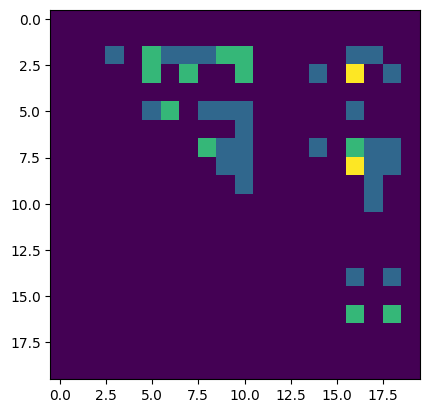

In [9]:
plt.imshow(data[1214])
print(data[0].shape)

# ML
## Create model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout
from keras import applications
from tensorflow.keras.utils import plot_model

def create_model():
    # base_model=applications.VGG16(include_top=False, weights='imagenet',input_tensor=Input(shape=(20, 21, 1)))
    # for layer in base_model.layers:
    #     layer.trainable = False
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(20,20,1)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### ROC Curve

In [11]:
def plot_roc_curve(fpr, tpr):
    fig = plt.figure(figsize=(15, 15)) 
    plt.plot(fpr,tpr, linewidth=6.0) 
    plt.axis([0,1,0,1]) 
    plt.title("ROC Curve for Antigen-Only Internal Residue Combination Frequency Chart Prediction")
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

## Run Model

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5166 - loss: 0.6928 - precision: 0.4460 - recall: 0.0409 - val_accuracy: 0.5761 - val_loss: 0.6906 - val_precision: 0.7111 - val_recall: 0.2623
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5918 - loss: 0.6908 - precision: 0.6338 - recall: 0.5476 - val_accuracy: 0.6461 - val_loss: 0.6881 - val_precision: 0.6800 - val_recall: 0.5574
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6236 - loss: 0.6887 - precision: 0.6270 - recall: 0.6802 - val_accuracy: 0.6296 - val_loss: 0.6845 - val_precision: 0.6860 - val_recall: 0.4836
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6085 - loss: 0.6859 - precision: 0.6144 - recall: 0.6396 - val_accuracy: 0.6420 - val_loss: 0.6798 - val_precision: 0.6882 - val_recall: 0.5246
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6278 - loss: 0.6810 - precision: 0.6316 - recall: 0.7002 - val_accuracy: 0.6420 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5087 - loss: 0.6930 - precision_1: 0.5135 - recall_1: 0.7916 - val_accuracy: 0.5432 - val_loss: 0.6922 - val_precision_1: 0.5414 - val_recall_1: 0.5902
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6238 - loss: 0.6910 - precision_1: 0.5991 - recall_1: 0.7257 - val_accuracy: 0.5720 - val_loss: 0.6906 - val_precision_1: 0.5549 - val_recall_1: 0.7459
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6197 - loss: 0.6888 - precision_1: 0.5854 - recall_1: 0.8655 - val_accuracy: 0.5679 - val_loss: 0.6885 - val_precision_1: 0.5620 - val_recall_1: 0.6311
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6317 - loss: 0.6867 - precision_1: 0.6153 - recall_1: 0.7209 - val_accuracy: 0.5679 - val_loss: 0.6851 - val_precision_1: 0.5659 - val_recall_1: 0.5984
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6239 - loss: 0.6833 - precision_1: 0.6204 - recall_1: 0.7533 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4991 - loss: 0.6929 - precision_2: 0.4991 - recall_2: 0.8144 - val_accuracy: 0.5926 - val_loss: 0.6916 - val_precision_2: 0.5596 - val_recall_2: 0.8852
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6087 - loss: 0.6909 - precision_2: 0.5801 - recall_2: 0.7907 - val_accuracy: 0.6214 - val_loss: 0.6897 - val_precision_2: 0.5843 - val_recall_2: 0.8525
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6213 - loss: 0.6879 - precision_2: 0.5973 - recall_2: 0.8080 - val_accuracy: 0.6337 - val_loss: 0.6870 - val_precision_2: 0.6065 - val_recall_2: 0.7705
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6395 - loss: 0.6850 - precision_2: 0.6106 - recall_2: 0.7397 - val_accuracy: 0.6502 - val_loss: 0.6834 - val_precision_2: 0.6082 - val_recall_2: 0.8525
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6388 - loss: 0.6806 - precision_2: 0.6155 - recall_2: 0.7631 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5086 - loss: 0.6930 - precision_3: 0.5096 - recall_3: 0.5556 - val_accuracy: 0.5761 - val_loss: 0.6913 - val_precision_3: 0.6301 - val_recall_3: 0.3770
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6324 - loss: 0.6903 - precision_3: 0.6537 - recall_3: 0.5660 - val_accuracy: 0.5967 - val_loss: 0.6892 - val_precision_3: 0.6000 - val_recall_3: 0.5902
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6439 - loss: 0.6874 - precision_3: 0.6675 - recall_3: 0.5818 - val_accuracy: 0.6132 - val_loss: 0.6860 - val_precision_3: 0.6458 - val_recall_3: 0.5082
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6224 - loss: 0.6832 - precision_3: 0.6303 - recall_3: 0.6257 - val_accuracy: 0.6091 - val_loss: 0.6810 - val_precision_3: 0.6709 - val_recall_3: 0.4344
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6411 - loss: 0.6773 - precision_3: 0.6555 - recall_3: 0.6017 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4841 - loss: 0.6933 - precision_4: 0.4762 - recall_4: 0.1595 - val_accuracy: 0.5802 - val_loss: 0.6918 - val_precision_4: 0.5806 - val_recall_4: 0.5902
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5816 - loss: 0.6911 - precision_4: 0.6547 - recall_4: 0.3404 - val_accuracy: 0.5556 - val_loss: 0.6899 - val_precision_4: 0.6250 - val_recall_4: 0.2869
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6059 - loss: 0.6888 - precision_4: 0.6171 - recall_4: 0.5982 - val_accuracy: 0.6337 - val_loss: 0.6873 - val_precision_4: 0.6364 - val_recall_4: 0.6311
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6267 - loss: 0.6852 - precision_4: 0.6233 - recall_4: 0.6640 - val_accuracy: 0.6091 - val_loss: 0.6838 - val_precision_4: 0.6239 - val_recall_4: 0.5574
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6200 - loss: 0.6812 - precision_4: 0.6242 - recall_4: 0.5585 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5292 - loss: 0.6927 - precision_5: 0.5935 - recall_5: 0.1695 - val_accuracy: 0.6420 - val_loss: 0.6909 - val_precision_5: 0.6545 - val_recall_5: 0.5950
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6140 - loss: 0.6904 - precision_5: 0.6260 - recall_5: 0.5362 - val_accuracy: 0.6584 - val_loss: 0.6888 - val_precision_5: 0.6418 - val_recall_5: 0.7107
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6118 - loss: 0.6884 - precision_5: 0.6073 - recall_5: 0.6310 - val_accuracy: 0.6337 - val_loss: 0.6861 - val_precision_5: 0.6053 - val_recall_5: 0.7603
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6109 - loss: 0.6855 - precision_5: 0.5757 - recall_5: 0.8232 - val_accuracy: 0.6379 - val_loss: 0.6816 - val_precision_5: 0.6486 - val_recall_5: 0.5950
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6429 - loss: 0.6808 - precision_5: 0.6584 - recall_5: 0.6348 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5326 - loss: 0.6924 - precision_6: 0.5269 - recall_6: 0.9039 - val_accuracy: 0.5556 - val_loss: 0.6914 - val_precision_6: 0.5355 - val_recall_6: 0.8099
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6090 - loss: 0.6905 - precision_6: 0.5724 - recall_6: 0.8218 - val_accuracy: 0.5679 - val_loss: 0.6893 - val_precision_6: 0.5449 - val_recall_6: 0.8017
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6224 - loss: 0.6881 - precision_6: 0.5920 - recall_6: 0.7461 - val_accuracy: 0.5844 - val_loss: 0.6864 - val_precision_6: 0.5549 - val_recall_6: 0.8347
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6395 - loss: 0.6836 - precision_6: 0.6044 - recall_6: 0.7972 - val_accuracy: 0.6049 - val_loss: 0.6823 - val_precision_6: 0.5969 - val_recall_6: 0.6364
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6395 - loss: 0.6780 - precision_6: 0.6178 - recall_6: 0.7992 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5170 - loss: 0.6930 - precision_7: 0.5743 - recall_7: 0.2614 - val_accuracy: 0.4938 - val_loss: 0.6923 - val_precision_7: 0.4722 - val_recall_7: 0.1405
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5769 - loss: 0.6910 - precision_7: 0.6310 - recall_7: 0.4472 - val_accuracy: 0.5885 - val_loss: 0.6905 - val_precision_7: 0.6129 - val_recall_7: 0.4711
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5998 - loss: 0.6894 - precision_7: 0.6426 - recall_7: 0.4581 - val_accuracy: 0.6091 - val_loss: 0.6882 - val_precision_7: 0.6182 - val_recall_7: 0.5620
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6413 - loss: 0.6851 - precision_7: 0.6505 - recall_7: 0.6055 - val_accuracy: 0.6132 - val_loss: 0.6849 - val_precision_7: 0.6116 - val_recall_7: 0.6116
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6338 - loss: 0.6819 - precision_7: 0.6554 - recall_7

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5166 - loss: 0.6924 - precision_8: 0.5158 - recall_8: 0.9895 - val_accuracy: 0.5432 - val_loss: 0.6908 - val_precision_8: 0.5278 - val_recall_8: 0.7851
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5930 - loss: 0.6907 - precision_8: 0.5726 - recall_8: 0.7023 - val_accuracy: 0.5844 - val_loss: 0.6883 - val_precision_8: 0.5526 - val_recall_8: 0.8678
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6084 - loss: 0.6885 - precision_8: 0.5711 - recall_8: 0.8176 - val_accuracy: 0.5967 - val_loss: 0.6846 - val_precision_8: 0.5628 - val_recall_8: 0.8512
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6268 - loss: 0.6843 - precision_8: 0.6008 - recall_8: 0.7653 - val_accuracy: 0.6296 - val_loss: 0.6795 - val_precision_8: 0.6026 - val_recall_8: 0.7521
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6166 - loss: 0.6790 - precision_8: 0.5997 - recall_8: 0.7797 - va

C:\Users\Tom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5114 - loss: 0.6928 - precision_9: 0.6206 - recall_9: 0.0047 - val_accuracy: 0.4938 - val_loss: 0.6921 - val_precision_9: 0.4750 - val_recall_9: 0.1570
Epoch 2/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5926 - loss: 0.6907 - precision_9: 0.6534 - recall_9: 0.4118 - val_accuracy: 0.6132 - val_loss: 0.6908 - val_precision_9: 0.6098 - val_recall_9: 0.6198
Epoch 3/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6425 - loss: 0.6885 - precision_9: 0.6149 - recall_9: 0.7643 - val_accuracy: 0.5926 - val_loss: 0.6889 - val_precision_9: 0.5932 - val_recall_9: 0.5785
Epoch 4/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6329 - loss: 0.6854 - precision_9: 0.6262 - recall_9: 0.6938 - val_accuracy: 0.5885 - val_loss: 0.6859 - val_precision_9: 0.5868 - val_recall_9: 0.5868
Epoch 5/1000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6411 - loss: 0.6802 - precision_9: 0.6314 - recall_9: 0.6572 - va

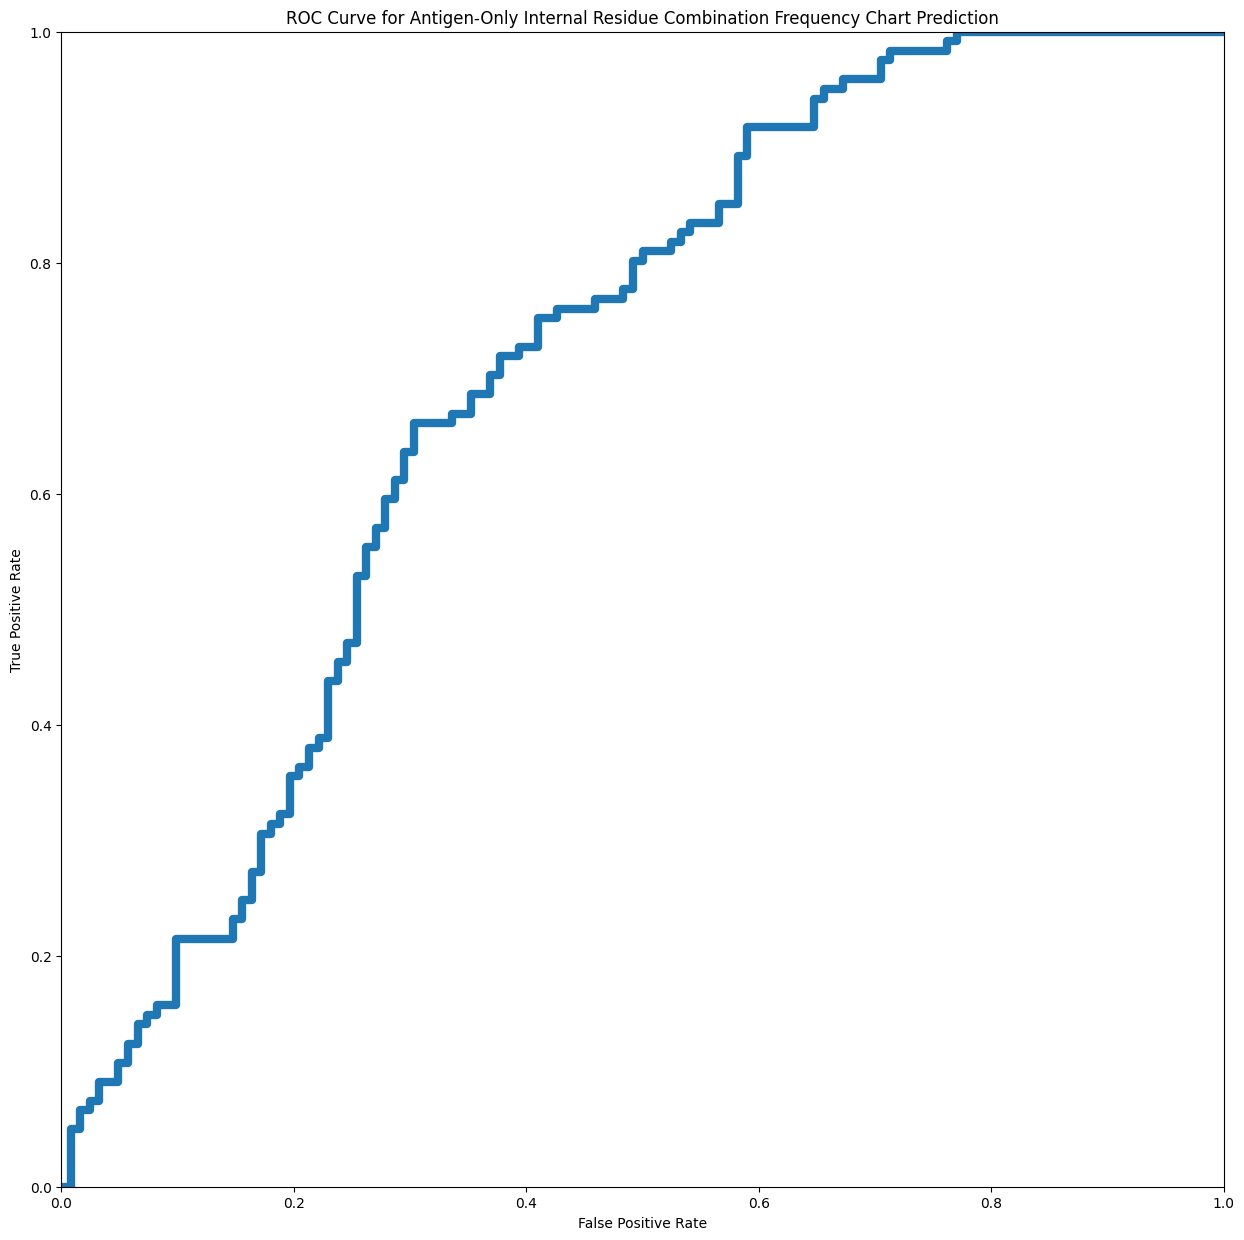

0.7053922232759788
[0.70658436 0.58327421 0.75759382 0.69584715 0.74155263 0.71523523]
[0.03472675 0.03577302 0.0412094  0.03865772 0.07515539 0.03784439]


In [12]:
from sklearn.model_selection import StratifiedKFold
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import roc_curve, roc_auc_score

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=9001)
accs, aucs, losses, precs, recs, f1s = [np.zeros(10) for _ in range(6)]

for i, (trainInds, testInds) in enumerate(kfold.split(data, labels)):
    # if i == 1:
    #     break
    model = create_model()
    X_train, X_test, y_train, y_test = data[trainInds], data[testInds], labels[trainInds], labels[testInds]
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy', Precision(), Recall()])
    
    # best_weights_file="weights.best.hdf5"
    # checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    es = EarlyStopping('val_accuracy', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=14,
                        validation_data=(X_test, y_test), callbacks=(es))
    # print(model.metrics_names)
    test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=1)
    accs[i] = test_acc
    losses[i] = test_loss
    precs[i] = test_prec
    recs[i] = test_rec
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    f1s[i] = test_f1
    prediction = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    auc_score=roc_auc_score(y_test, prediction)
    aucs[i] = auc_score
    if i == 9:
        plot_roc_curve(fpr,tpr)
        print(auc_score)

print(np.mean(np.array([accs, losses, aucs, precs, recs, f1s]), axis=1))
print(np.std(np.array([accs, losses, aucs, precs, recs, f1s]), axis=1))